# Face Mask Detector

## #1 - Training the COVID-19 face mask detector with Keras/TensorFlow

In [1]:
# Import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [ ]:
# # Construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-a", "--masked-dataset", required=True,
#     help="path to masked dataset")
# ap.add_argument("-b", "--unmasked-dataset", required=True,
#     help="path to unmasked dataset")
# ap.add_argument("-d", "--dataset", required=True,
#     help="path to input dataset")
# ap.add_argument("-p", "--plot", type=str, default="loss_accuracy.png",
#     help="path to output loss/accuracy plot")
# ap.add_argument("-m", "--model", type=str,
#     default="mask_detector.model",
#     help="path to output face mask detector model")
# args = vars(ap.parse_args())

In [2]:
# Construct the argument parser and parse the arguments
args = dict()
args['masked_dataset_path'] = os.getcwd()+'/dataset/masked-images-64'
args['unmasked_dataset_path'] = os.getcwd()+'/dataset/unmasked-images-64'
args['model'] = 'mask_detector.model'
args['plot'] = 'loss_accuracy.png'

In [3]:
# Initialize learning rate,epochs number and batch size
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 32

### 64x64 Images

In [4]:
# Loading dataset
print("[INFO] loading images...")

data = []
labels = []

for image_path in list(paths.list_images(args['masked_dataset_path'])):
    # Load the input image (64x64) and preprocess it
    image = load_img(image_path, target_size=(64, 64))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append('masked')
for image_path in list(paths.list_images(args['unmasked_dataset_path'])):
    # Load the input image (64x64) and preprocess it
    image = load_img(image_path, target_size=(64, 64))
    image = img_to_array(image)
    image = preprocess_input(image) # Scaling the pixel intensities in the input image to the range [-1, 1]
    data.append(image)
    labels.append('unmasked')

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] loading images...


In [5]:
# Perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [6]:
# Partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [7]:
# Construct the training image generator to generate batches of tensor image data with real-time data
# augmentation
# During training, we’ll be applying on-the-fly mutations to our images in an effort to improve generalization
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [8]:
# Load the MobileNetV2 network, ensuring the head FC layer sets are left off
base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(64, 64, 3)))

# Construct the head of the model that will be placed on top of the the base model
head_model = base_model.output
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

# Place the head FC model on top of the base model
model = Model(inputs=base_model.input, outputs=head_model)

# Loop over all layers in the base model and freeze them so they will *not* be updated during the first
# training process
for layer in base_model.layers:
    layer.trainable = False

In [9]:
# Compile our model
print("[INFO] compiling model...")
opt = Adam(lr=LEARNING_RATE, decay=LEARNING_RATE / NUM_EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


/Users/alansary/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:
# Train the head of the network
print("[INFO] training head...")
history = model.fit(
    aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    validation_data=(X_test, y_test),
    validation_steps=len(X_test) // BATCH_SIZE,
    epochs=NUM_EPOCHS)

[INFO] training head...
Epoch 1/20
38/38 [==============================] - 3s 39ms/step - loss: 0.7694 - accuracy: 0.6188 - val_loss: 0.5964 - val_accuracy: 0.6839
Epoch 2/20
38/38 [==============================] - 1s 23ms/step - loss: 0.6591 - accuracy: 0.6586 - val_loss: 0.5656 - val_accuracy: 0.6968
Epoch 3/20
38/38 [==============================] - 1s 23ms/step - loss: 0.6028 - accuracy: 0.6910 - val_loss: 0.5468 - val_accuracy: 0.7194
Epoch 4/20
38/38 [==============================] - 1s 23ms/step - loss: 0.5843 - accuracy: 0.7110 - val_loss: 0.5347 - val_accuracy: 0.7290
Epoch 5/20
38/38 [==============================] - 1s 22ms/step - loss: 0.5797 - accuracy: 0.7143 - val_loss: 0.5273 - val_accuracy: 0.7290
Epoch 6/20
38/38 [==============================] - 1s 23ms/step - loss: 0.5612 - accuracy: 0.7193 - val_loss: 0.5189 - val_accuracy: 0.7387
Epoch 7/20
38/38 [==============================] - 1s 23ms/step - loss: 0.5664 - accuracy: 0.7251 - val_loss: 0.5135 - val_accura

In [11]:
# Make predictions on the testing set
print("[INFO] evaluating network...")
pred_idxs = model.predict(X_test, batch_size=BATCH_SIZE)

# For each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
pred_idxs = np.argmax(pred_idxs, axis=1)

# Classification report
print(classification_report(y_test.argmax(axis=1), pred_idxs, target_names=lb.classes_))

# Serialize the model to disk
print("[INFO] saving mask detector model...")
model.save(args['model'], save_format="h5")

[INFO] evaluating network...
              precision    recall  f1-score   support

      masked       0.70      0.66      0.68       133
    unmasked       0.76      0.79      0.77       177

    accuracy                           0.73       310
   macro avg       0.73      0.72      0.72       310
weighted avg       0.73      0.73      0.73       310

[INFO] saving mask detector model...


/Users/alansary/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


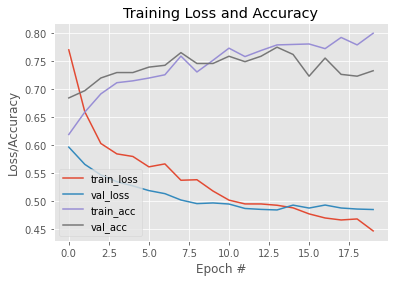

In [12]:
# Plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, NUM_EPOCHS), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args['plot'])

### 224x224 Images

In [ ]:
# To obain much better accuracy, we can refine our model by increasing the size of the image to 224x224
# and applying average pooling of 7x7

In [ ]:
# # Construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-a", "--masked-dataset", required=True,
#     help="path to masked dataset")
# ap.add_argument("-b", "--unmasked-dataset", required=True,
#     help="path to unmasked dataset")
# ap.add_argument("-d", "--dataset", required=True,
#     help="path to input dataset")
# ap.add_argument("-p", "--plot", type=str, default="loss_accuracy.png",
#     help="path to output loss/accuracy plot")
# ap.add_argument("-m", "--model", type=str,
#     default="mask_detector.model",
#     help="path to output face mask detector model")
# args = vars(ap.parse_args())

In [15]:
# Construct the argument parser and parse the arguments
args = dict()
args['masked_dataset_path'] = os.getcwd()+'/dataset/masked-images'
args['unmasked_dataset_path'] = os.getcwd()+'/dataset/unmasked-images'
args['model'] = 'mask_detector_224x224.model'
args['plot'] = 'loss_accuracy_224x224.png'

In [16]:
# Loading dataset
print("[INFO] loading images...")

data = []
labels = []

for image_path in list(paths.list_images(args['masked_dataset_path'])):
    # Load the input image (224x224) and preprocess it
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append('masked')
for image_path in list(paths.list_images(args['unmasked_dataset_path'])):
    # Load the input image (224x224) and preprocess it
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image) # Scaling the pixel intensities in the input image to the range [-1, 1]
    data.append(image)
    labels.append('unmasked')

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] loading images...


/Users/alansary/miniforge3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (89981136 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/alansary/miniforge3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (133330000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/alansary/miniforge3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (144000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [17]:
# Perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [18]:
# Partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [19]:
# Construct the training image generator to generate batches of tensor image data with real-time data
# augmentation
# During training, we’ll be applying on-the-fly mutations to our images in an effort to improve generalization
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [20]:
# Load the MobileNetV2 network, ensuring the head FC layer sets are left off
base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Construct the head of the model that will be placed on top of the the base model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

# Place the head FC model on top of the base model
model = Model(inputs=base_model.input, outputs=head_model)

# Loop over all layers in the base model and freeze them so they will *not* be updated during the first
# training process
for layer in base_model.layers:
    layer.trainable = False

In [21]:
# Compile our model
print("[INFO] compiling model...")
opt = Adam(lr=LEARNING_RATE, decay=LEARNING_RATE / NUM_EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


/Users/alansary/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
# Train the head of the network
print("[INFO] training head...")
history = model.fit(
    aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    validation_data=(X_test, y_test),
    validation_steps=len(X_test) // BATCH_SIZE,
    epochs=NUM_EPOCHS)

[INFO] training head...
Epoch 1/20
38/38 [==============================] - 10s 222ms/step - loss: 0.7632 - accuracy: 0.5540 - val_loss: 0.5784 - val_accuracy: 0.7613
Epoch 2/20
38/38 [==============================] - 8s 205ms/step - loss: 0.5828 - accuracy: 0.7342 - val_loss: 0.4818 - val_accuracy: 0.8161
Epoch 3/20
38/38 [==============================] - 9s 234ms/step - loss: 0.4985 - accuracy: 0.7965 - val_loss: 0.4164 - val_accuracy: 0.8548
Epoch 4/20
38/38 [==============================] - 8s 200ms/step - loss: 0.4262 - accuracy: 0.8397 - val_loss: 0.3698 - val_accuracy: 0.8806
Epoch 5/20
38/38 [==============================] - 8s 211ms/step - loss: 0.3752 - accuracy: 0.8704 - val_loss: 0.3363 - val_accuracy: 0.8839
Epoch 6/20
38/38 [==============================] - 8s 199ms/step - loss: 0.3561 - accuracy: 0.8663 - val_loss: 0.3124 - val_accuracy: 0.8935
Epoch 7/20
38/38 [==============================] - 8s 212ms/step - loss: 0.3305 - accuracy: 0.8754 - val_loss: 0.2966 - va

In [23]:
# Make predictions on the testing set
print("[INFO] evaluating network...")
pred_idxs = model.predict(X_test, batch_size=BATCH_SIZE)

# For each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
pred_idxs = np.argmax(pred_idxs, axis=1)

# Classification report
print(classification_report(y_test.argmax(axis=1), pred_idxs, target_names=lb.classes_))

# Serialize the model to disk
print("[INFO] saving mask detector model...")
model.save('mask_detector_224x224.model', save_format="h5")

[INFO] evaluating network...
              precision    recall  f1-score   support

      masked       0.91      0.88      0.89       133
    unmasked       0.91      0.93      0.92       177

    accuracy                           0.91       310
   macro avg       0.91      0.91      0.91       310
weighted avg       0.91      0.91      0.91       310

[INFO] saving mask detector model...


/Users/alansary/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


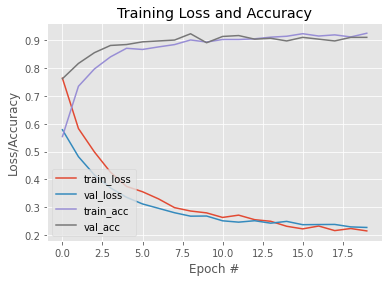

In [24]:
# Plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, NUM_EPOCHS), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('loss_accuracy_224x224.png')

## #2 - Implementing our COVID-19 face mask detector for images with OpenCV

In [25]:
# Import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os

In [26]:
# # Construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True,
#     help="path to input image")
# ap.add_argument("-f", "--face", type=str,
#     help="path to face detector model directory")
# ap.add_argument("-m", "--model", type=str,
#     default="mask_detector_224x224.model",
#     help="path to trained face mask detector model")
# ap.add_argument("-c", "--confidence", type=float, default=0.5,
#     help="minimum probability to filter weak detections")
# args = vars(ap.parse_args())

In [86]:
# Construct the argument parser and parse the arguments
args = dict()
args['image'] = os.getcwd()+'/dataset/model_testing/mask_image.jpg'
args['face'] = os.getcwd()+'/face_detector'
args['model'] = 'mask_detector_224x224.model'
args['confidence'] = 0.5

In [87]:
# Load the serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxt_path = args['face'] + '/deploy.prototxt'
weights_path = args['face'] + '/res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNet(prototxt_path, weights_path)

# Load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model = load_model(args["model"])

[INFO] loading face detector model...
[INFO] loading face mask detector model...


In [88]:
# Load the input image from disk, clone it, and grab the image spatial dimensions
image = cv2.imread(args["image"])
original = image.copy()
(h, w) = image.shape[:2]

# Construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))

# Pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing face detections...


In [89]:
# Loop over the detections and extract the confidence to measure against the args confidence threshold
for i in range(0, detections.shape[2]):
    # Extract the confidence (i.e., probability) associated with the detection
    confidence = detections[0, 0, i, 2]
    # Filter out weak detections by ensuring the confidence is greater than the minimum confidence
    if confidence > args["confidence"]:
        # Compute the (x, y)-coordinates of the bounding box for the object
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        # Ensure the bounding boxes fall within the dimensions of the frame
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

In [90]:
# Extract the face ROI, convert it from BGR to RGB channel
# ordering, resize it to 224x224, and preprocess it

face = image[startY:endY, startX:endX] # Extract the face ROI via NumPy slicing
# Pre-process the ROI
face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
face = cv2.resize(face, (224, 224))
face = img_to_array(face)
face = preprocess_input(face)
face = np.expand_dims(face, axis=0)

# Pass the face through the model to determine if the face has a mask or not
(mask, without_mask) = model.predict(face)[0]

In [91]:
# Determine the class label and color we'll use to draw the bounding box and text
label = "Mask" if mask > without_mask else "No Mask"
color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

# Include the probability in the label
label = "{}: {:.2f}%".format(label, max(mask, without_mask) * 100)

# Display the label and bounding box rectangle on the output frame
cv2.putText(image, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# show the output image
cv2.imshow("Output", image)
cv2.waitKey(0)

48

## #3 - Implementing our COVID-19 face mask detector in real-time video streams with OpenCV

In [1]:
# Import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os

In [9]:
# This algorithm is the same as before but processes each frame of the webcam stream

def detect_and_predict_mask(frame, face_net, mask_net):
    """
    - frame: A frame from our stream
    - face_net: The model used to detect where in the image faces are
    - mask_net: Our COVID-19 face mask classifier model
    """
    # Grab the dimensions of the frame and then construct a blob from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), (104.0, 177.0, 123.0))
    # Pass the blob through the network and obtain the face detections
    face_net.setInput(blob)
    detections = face_net.forward()
    # Initialize our list of faces, their corresponding locations,
    # and the list of predictions from our face mask network
    faces = [] # ROIs
    locs = [] # Face locations
    preds = [] # Mask/No-Mask predictions

    # Loop over the detections
    for i in range(0, detections.shape[2]):
        # Extract the confidence (i.e., probability) associated with the detection
        confidence = detections[0, 0, i, 2]

        # Filter out weak detections by ensuring the confidence is greater than the minimum confidence
        if confidence > args["confidence"]:
            # Compute the (x, y)-coordinates of the bounding box for the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # Ensure the bounding boxes fall within the dimensions of the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # Extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

            # Add the face and bounding boxes to their respective lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))

    # Only make a predictions if at least one face was detected
    if len(faces) > 0:
        # For faster inference we'll make batch predictions on all
        # faces at the same time rather than one-by-one predictions
        # in the above `for` loop
        faces = np.array(faces, dtype="float32")
        preds = mask_net.predict(faces, batch_size=32)

    # Return a 2-tuple of the face locations and their corresponding locations
    return (locs, preds)

In [3]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-f", "--face", type=str,
#     help="path to face detector model directory")
# ap.add_argument("-m", "--model", type=str,
#     default="mask_detector.model",
#     help="path to trained face mask detector model")
# ap.add_argument("-c", "--confidence", type=float, default=0.5,
#     help="minimum probability to filter weak detections")
# args = vars(ap.parse_args())

In [11]:
# Construct the argument parser and parse the arguments
args = dict()
args['face'] = os.getcwd()+'/face_detector'
args['model'] = 'mask_detector_224x224.model'
args['confidence'] = 0.5

In [12]:
# Load the serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxt_path = args['face'] + '/deploy.prototxt'
weights_path = args['face'] + '/res10_300x300_ssd_iter_140000.caffemodel'
face_net = cv2.dnn.readNet(prototxt_path, weights_path)

# Load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
mask_net = load_model(args["model"])

[INFO] loading face detector model...
[INFO] loading face mask detector model...


In [18]:
# Initialize the video stream and allow the camera sensor to warm up
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()
time.sleep(2.0)

[INFO] starting video stream...


In [19]:
# Loop over the frames from the video stream
while True:
    # Grab the frame from the threaded video stream and resize it
    # to have a maximum width of 400 pixels
    frame = vs.read()
    frame = imutils.resize(frame, width=800)
    # Detect faces in the frame and determine if they are wearing a
    # face mask or not
    (locs, preds) = detect_and_predict_mask(frame, face_net, mask_net)

    # Loop over the detected face locations and their corresponding locations
    for (box, pred) in zip(locs, preds):
        # Unpack the bounding box and predictions
        (startX, startY, endX, endY) = box
        (mask, without_mask) = pred
        # Determine the class label and color we'll use to draw the bounding box and text
        label = "Mask" if mask > without_mask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        # Include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, without_mask) * 100)
        # Display the label and bounding box rectangle on the output frame
        cv2.putText(frame, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

    # Show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

# Do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

## Resources
- A highly efficient architecture that can be applied to embedded devices with limited computational capacity (ex., Raspberry Pi, Google Coral, NVIDIA Jetson Nano, etc.). Deploying our face mask detector to embedded devices could reduce the cost of manufacturing such face mask detection systems.<br/>[MobileNetV2: Inverted Residuals and Linear Bottlenecks](https://arxiv.org/abs/1801.04381)
- We will fine-tune this model with pre-trained ImageNet weights.<br/>[ImageNet](https://image-net.org/)
- OpenCV’s deep learning face detector based on the Single Shot Detector (SSD) framework with a ResNet base network.<br/>[Caffe-based face detector](https://github.com/opencv/opencv/tree/master/samples/dnn/face_detector)
<br/>[Caffe-based face detector .prototxt file which defines the model architecture](https://github.com/opencv/opencv/blob/master/samples/dnn/face_detector/deploy.prototxt)
<br/>[Caffe-based face detector .caffemodel file which contains the weights for the actual layers](https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel)